# Colorization

## Library Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from skimage import color

## Preparation of the dataset

In [2]:
# Custom Dataset Class for CIFAR-10 Colorization
class CIFAR10ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        self.cifar10 = datasets.CIFAR10(root='../data', train=train, download=True)
        self.data = self.cifar10.data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        img_lab = color.rgb2lab(img).astype("float32")  # Convert to LAB color space

        # Normalize L and ab channels
        L = img_lab[:, :, 0] / 50.0 - 1.0  # L channel in [-1, 1]
        ab = img_lab[:, :, 1:] / 110.0  # ab channels in [-1, 1]

        # Convert to tensors
        L = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab).permute(2, 0, 1)

        return L, ab

In [3]:
# Data Loaders
batch_size = 64

train_dataset = CIFAR10ColorizationDataset(train=True)
test_dataset = CIFAR10ColorizationDataset(train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


## Model Definition

In [4]:
# Model Definition
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # (B, 64, 32, 32)
            nn.ReLU(inplace=True),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (B, 128, 16, 16)
            nn.ReLU(inplace=True),
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (B, 256, 8, 8)
            nn.ReLU(inplace=True),
        )
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # (B, 512, 8, 8)
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 256, 16, 16)
            nn.ReLU(inplace=True),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 128, 32, 32)
            nn.ReLU(inplace=True),
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # (B, 64, 32, 32)
            nn.ReLU(inplace=True),
        )
        self.dec4 = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=3, padding=1),  # (B, 2, 32, 32)
            nn.Tanh(),  # Output in [-1, 1]
        )

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        return x

## Training

In [12]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
# Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (L, ab) in enumerate(train_loader):
        L, ab = L.to(device), ab.to(device)

        optimizer.zero_grad()
        output_ab = model(L)
        loss = criterion(output_ab, ab)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Compute loss on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for L, ab in test_loader:
            L, ab = L.to(device), ab.to(device)
            output_ab = model(L)
            test_loss += criterion(output_ab, ab).item()


    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")

# Save the Model
torch.save(model.state_dict(), 'colorization_model.pth')

Epoch [1/10], Step [100/782], Loss: 0.0133
Epoch [1/10], Step [200/782], Loss: 0.0136
Epoch [1/10], Step [300/782], Loss: 0.0121
Epoch [1/10], Step [400/782], Loss: 0.0127
Epoch [1/10], Step [500/782], Loss: 0.0097
Epoch [1/10], Step [600/782], Loss: 0.0153
Epoch [1/10], Step [700/782], Loss: 0.0130
Epoch [1/10], Training Loss: 0.0139, Test Loss: 0.0134
Epoch [2/10], Step [100/782], Loss: 0.0133
Epoch [2/10], Step [200/782], Loss: 0.0167
Epoch [2/10], Step [300/782], Loss: 0.0145
Epoch [2/10], Step [400/782], Loss: 0.0139
Epoch [2/10], Step [500/782], Loss: 0.0155
Epoch [2/10], Step [600/782], Loss: 0.0105
Epoch [2/10], Step [700/782], Loss: 0.0151
Epoch [2/10], Training Loss: 0.0130, Test Loss: 0.0126
Epoch [3/10], Step [100/782], Loss: 0.0134
Epoch [3/10], Step [200/782], Loss: 0.0144
Epoch [3/10], Step [300/782], Loss: 0.0130
Epoch [3/10], Step [400/782], Loss: 0.0142
Epoch [3/10], Step [500/782], Loss: 0.0142
Epoch [3/10], Step [600/782], Loss: 0.0153
Epoch [3/10], Step [700/782], 

In [7]:
# Visualization Function
def visualize_output(model, data_loader, n_images=5):
    count_images = 0
    model.eval()
    with torch.no_grad():
        for L, ab in data_loader:
            L = L.to(device)
            output_ab = model(L)
            output_ab = output_ab.cpu()

            # Denormalize L and ab
            L = L.cpu() * 50.0 + 50.0
            ab = ab * 110.0
            output_ab = output_ab * 110.0

            # Convert L and ab to numpy
            L = L.squeeze(1).numpy()
            ab = ab.numpy()
            output_ab = output_ab.numpy()

            # Iterate over images in batch
            for i in range(len(L)):
                count_images += 1
                
                original_lab = np.zeros((32, 32, 3))
                original_lab[:, :, 0] = L[i]
                original_lab[:, :, 1:] = ab[i].transpose(1, 2, 0)
                original_rgb = color.lab2rgb(original_lab)

                output_lab = np.zeros((32, 32, 3))
                output_lab[:, :, 0] = L[i]
                output_lab[:, :, 1:] = output_ab[i].transpose(1, 2, 0)
                output_rgb = color.lab2rgb(output_lab)

                grayscale_img = color.gray2rgb(L[i] / 100.0)

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(grayscale_img)
                axs[0].set_title('Input L')
                axs[0].axis('off')

                axs[1].imshow(output_rgb)
                axs[1].set_title('Predicted Color')
                axs[1].axis('off')

                axs[2].imshow(original_rgb)
                axs[2].set_title('Original Color')
                axs[2].axis('off')

                plt.show()
                
                if count_images == n_images:
                    break
            
            if count_images == n_images:
                break

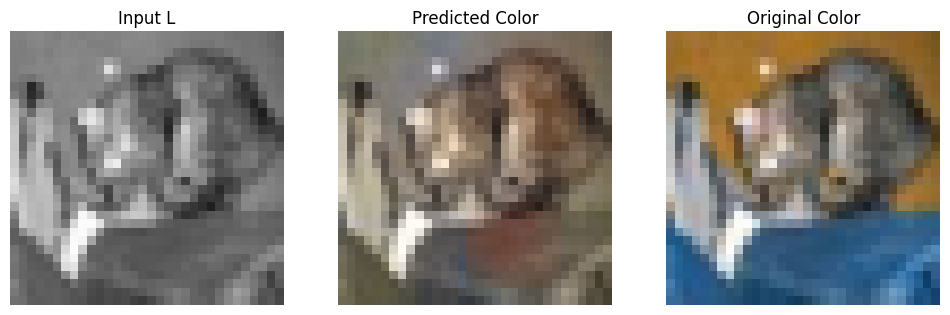

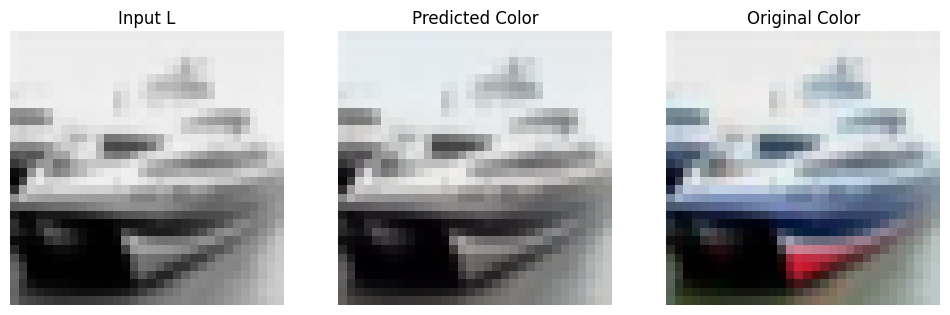

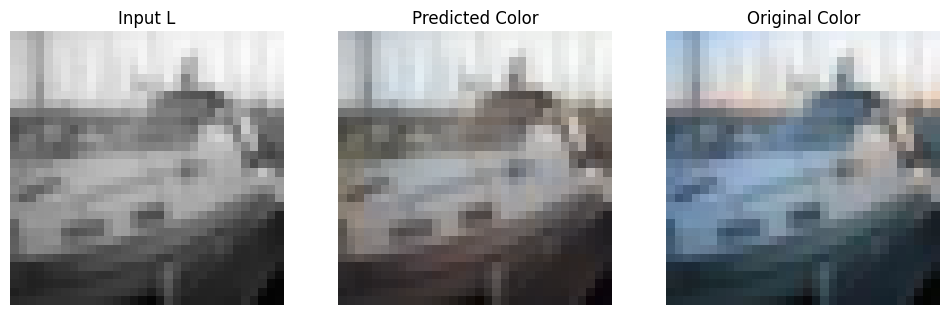

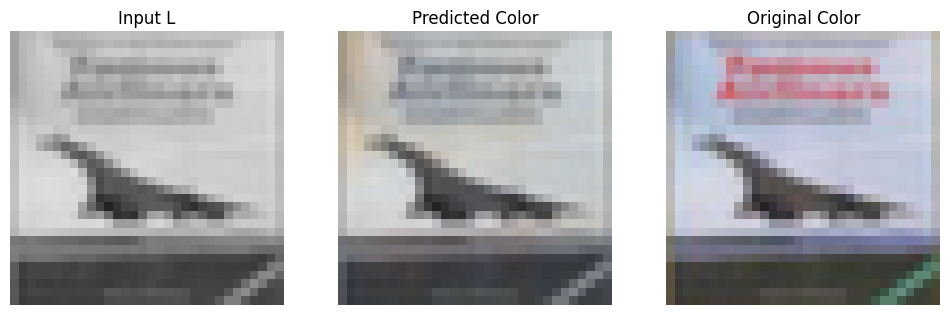

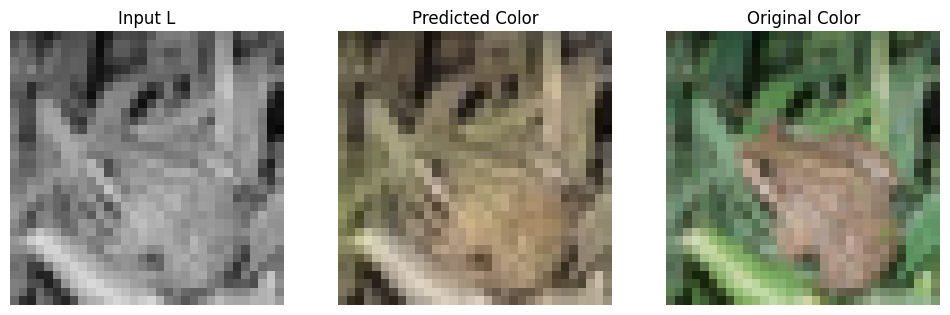

In [8]:
# Visualize the Results
visualize_output(model, test_loader)

## Transferable Representations?

### Define the Classifier Model

In [ ]:
class ClassifierNet(nn.Module):
    def __init__(self, encoder):
        super(ClassifierNet, self).__init__()
        self.encoder = encoder  # Pre-trained encoder from colorization model
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(512 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)  # CIFAR-10 has 10 classes
        )

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder.enc1(x)
            x = self.encoder.enc2(x)
            x = self.encoder.enc3(x)
            x = self.encoder.enc4(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x